In [2]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
with open("graph.json", "r") as f:
    data = json.load(f)
G = nx.node_link_graph(data)  


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Loading the graph and applying the further methods 

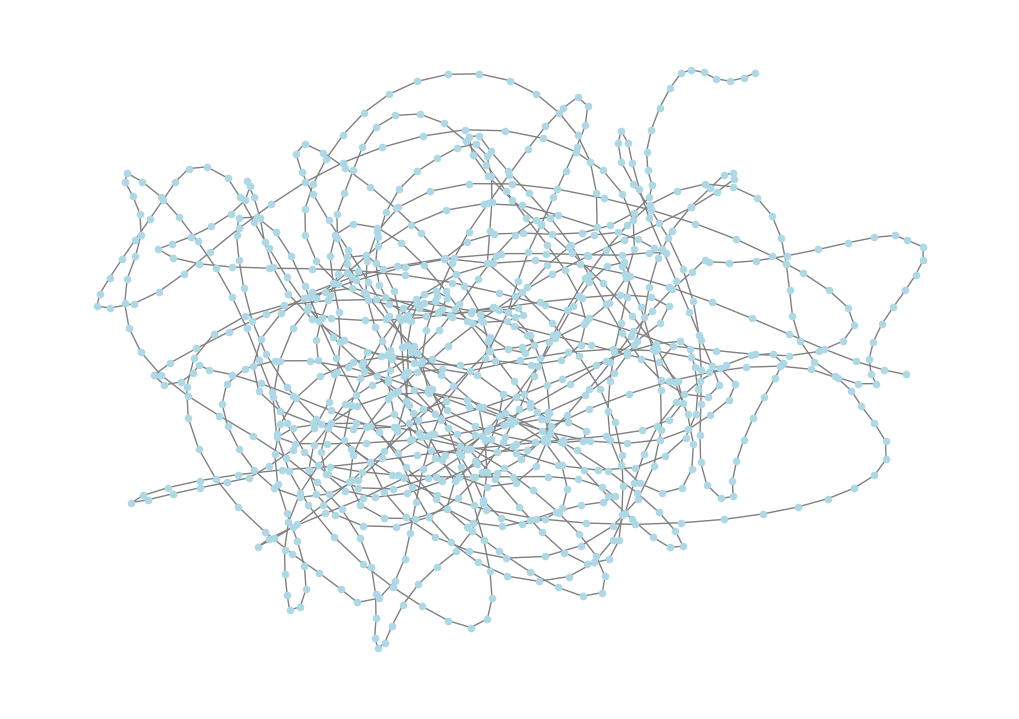

In [3]:
def visualize_graph_without(G):
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)  

    
    nx.draw(G, pos, node_color="lightblue", node_size=20, edge_color='gray', with_labels=False)

    plt.show()
visualize_graph_without(G)    

In [4]:
def compute_centrality(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=10)  # Approximation
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)

    centrality_scores = {}
    for node in G.nodes():
        d = degree_centrality[node]
        c = closeness_centrality[node]
        b = betweenness_centrality[node]
        e = eigenvector_centrality[node]
        centrality_scores[node] = d + c + b + e

    return centrality_scores, degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality
c = compute_centrality(G)

In [5]:


def compute_centrality_matx(G):
    """Compute multiple centrality measures and return them in a structured format."""
    
    # Compute different centrality measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=10)  
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)


    nodes = list(G.nodes())


    centrality_matrix = np.array([
        [degree_centrality[node], closeness_centrality[node], 
         betweenness_centrality[node], eigenvector_centrality[node]] 
        for node in nodes
    ])
 
    combined_score = centrality_matrix.sum(axis=1)  

    return (
        dict(zip(nodes, combined_score)), 
        centrality_matrix,                
        degree_centrality,                 
        closeness_centrality,              
        betweenness_centrality,            
        eigenvector_centrality
    )


In [6]:
def compute_pca_weights(centrality_matrix):
    """ Compute PCA-based weights for centrality measures. """
    
    centrality_matrix = np.array(centrality_matrix)

    if len(centrality_matrix.shape) != 2 or centrality_matrix.shape[1] != 4:
        raise ValueError(f"Expected shape (N, 4), but got {centrality_matrix.shape}")

    X_scaled = StandardScaler().fit_transform(centrality_matrix)

    pca = PCA(n_components=1)
    pca.fit(X_scaled)

    weights = pca.components_[0]
    weights /= np.sum(np.abs(weights))  1

    return weights

In [7]:
a1,a2,a3,a4,a5,a6 = compute_centrality_matx(G)
a2

array([[2.00200200e-03, 1.72765634e-02, 5.90603964e-02, 1.05202206e-12],
       [2.00200200e-03, 1.91119359e-02, 4.23268960e-02, 5.44952272e-07],
       [2.00200200e-03, 2.00056072e-02, 3.62754204e-03, 6.22915335e-07],
       ...,
       [2.00200200e-03, 1.93428466e-02, 3.29654972e-02, 4.74535027e-08],
       [2.00200200e-03, 1.39320828e-02, 4.79771689e-02, 3.07429196e-17],
       [2.00200200e-03, 1.13618270e-02, 3.00902105e-03, 2.13868267e-20]])

In [8]:
compute_pca_weights(a2)

array([0.24983812, 0.29514461, 0.29210217, 0.16291511])

In [9]:
c = compute_centrality(G)

Getting the weights from the PCA algorithm without the normalization 

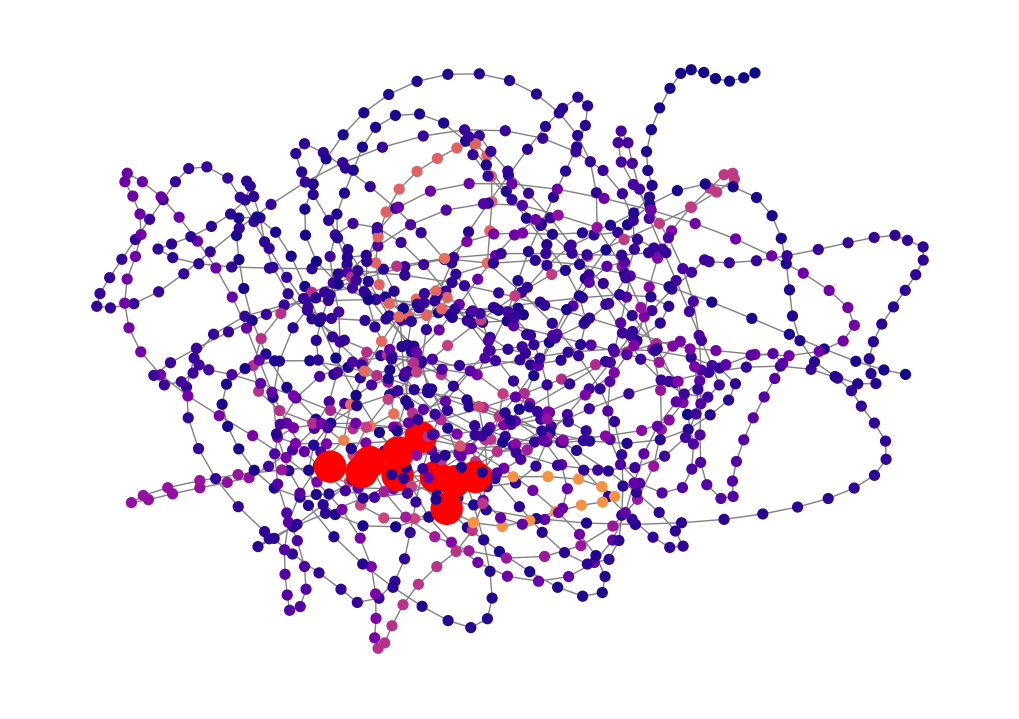


üöÄ **Top 10 Nodes by Updated Centrality** üöÄ
üèÜ Rank 1: Node 994 ‚Üí Centrality: 0.20585
üèÜ Rank 2: Node 908 ‚Üí Centrality: 0.20029
üèÜ Rank 3: Node 907 ‚Üí Centrality: 0.19057
üèÜ Rank 4: Node 804 ‚Üí Centrality: 0.17076
üèÜ Rank 5: Node 777 ‚Üí Centrality: 0.16463
üèÜ Rank 6: Node 669 ‚Üí Centrality: 0.16228
üèÜ Rank 7: Node 761 ‚Üí Centrality: 0.15563
üèÜ Rank 8: Node 213 ‚Üí Centrality: 0.15511
üèÜ Rank 9: Node 107 ‚Üí Centrality: 0.15479
üèÜ Rank 10: Node 850 ‚Üí Centrality: 0.15458


In [13]:


def compute_combined_centrality(c, weights):
    """ Compute new centrality scores using PCA-based weights. """
    
    w, x, y, z = weights  

    new_centrality_scores = {
        node: (w * c[0][node] + x * c[1][node] + y * c[2][node] + z * c[3][node])
        for node in c[0].keys()  # Assuming all dicts have the same keys
    }
    
    return new_centrality_scores

def visualize_updated_graph(G, new_scores):
    """ Visualize the graph with new centrality scores, highlighting top 10 nodes. """
    
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42) 

    sorted_nodes = sorted(new_scores.items(), key=lambda x: x[1], reverse=True)
    top_10_nodes = {node for node, _ in sorted_nodes[:10]}

    scores = np.array(list(new_scores.values()))
    min_score, max_score = min(scores), max(scores)
    normalized_scores = (scores - min_score) / (max_score - min_score)
    
    node_colors = ["red" if node in top_10_nodes else plt.cm.plasma(score) 
                   for node, score in zip(new_scores.keys(), normalized_scores)]
    
    node_sizes = [500 if node in top_10_nodes else 50 for node in G.nodes]

    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, edge_color="gray", with_labels=False)

    plt.show()

def print_top_10_nodes(new_scores):
    """ Print the top 10 nodes with the highest new centrality scores. """
    
    sorted_nodes = sorted(new_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    print("\nüöÄ **Top 10 Nodes by Updated Centrality** üöÄ")
    print("=" * 40)
    for rank, (node, score) in enumerate(sorted_nodes, start=1):
        print(f"üèÜ Rank {rank}: Node {node} ‚Üí Centrality: {score:.5f}")
    print("=" * 40)

new_scores = compute_combined_centrality(c, np.array([0.24743395, 0.30383686, 0.3020864 , 0.14664279]))

visualize_updated_graph(G, new_scores)

print_top_10_nodes(new_scores)
